### UNO Random Simulator

Ok, so, let's do some fun, free programming of a game: namely UNO. I don't know how it will go, i don't know if i'm going to get anything useful, i just need to work on something without much pressure right now. I think i'm going to simplify the rules a little bit, and check on some statistics. Some interesting things i would like to get are:

-Distribution of steps that it takes to win the game

-Distribution of the maximum number of cards that any player gets at a game

-Distribution of the maximum number of cards that the winner gets at a game 



In [44]:
from enum import Enum
import random
import numpy as np
import matplotlib.pyplot as plt

In [45]:
class CardType(Enum):
    NORMAL = 0
    TAKE_TWO = 1
    TAKE_FOUR = 2
    REVERSE = 3
    SKIP = 4
    WILD= 5
    
class CardColor(Enum):
    GREEN = 0
    RED = 1
    BLUE = 2
    YELLOW = 3
    
    
class Card:
    
    def __init__(self, cardType, cardColor = -1, cardNumber = -1):
        self.cardType = cardType
        self.cardColor = cardColor
        self.cardNumber = cardNumber
    
    def __eq__(self, other):
        return self.cardType == other.cardType and self.cardColor == other.cardColor and self.cardNumber == other.cardNumber
        

class UNODeck:
    
    def initializeEmptyDeck(self):
        self.cards = []
    
    #Initialize the UNO deck
    def initializeDeck(self):
        self.cards = []
        #Initialize the cards with color
        cardColors = [CardColor.GREEN, CardColor.RED, CardColor.BLUE, CardColor.YELLOW]
        for i in range(0,len(cardColors)):
            cardColor = cardColors[i]
            #Cards from 0 to 9

            for i in range(0,10):
                #One 0 and 2 of all the other numbers
                if(i == 0):
                    cardType = CardType.NORMAL
                    card = Card(cardType, cardColor, i)
                    self.cards.append(card)
                else:
                    cardType = CardType.NORMAL
                    card1 = Card(cardType, cardColor, i)
                    card2 = Card(cardType, cardColor, i)
                    self.cards.append(card1)
                    self.cards.append(card2)
            cardSpecialTypes = [CardType.TAKE_TWO, CardType.REVERSE, CardType.SKIP]
            #Two cards of the other types
            for i in range(0,len(cardSpecialTypes)):
                specialType = cardSpecialTypes[i]
                for j in range(0,2):
                    card = Card(specialType, cardColor)
                    self.cards.append(card)
            #Finally add 4 draw 4s and 4 wild cards
        for i in range(0,4):
            takeFourCard = Card(CardType.TAKE_FOUR)
            wildCard = Card(CardType.WILD)
            self.cards.append(takeFourCard)
            self.cards.append(wildCard)
        
        self.shuffleDeck()
    
    def getCardNumber(self):
        return len(self.cards)
    
    def shuffleDeck(self):
        random.shuffle(self.cards)
    
    def takeCard(self):
        if(self.getCardNumber() > 0):
            return self.cards.pop(0)
        else:
            return Card(-1,-1,-1)
    
    def addCard(self, card):
        self.cards.append(card)
    
    def lookAtLastCard(self):
        return self.cards[self.getCardNumber()-1]
        
class UNOGame:
    
    def __init__(self, numberOfPlayers):

        self.nPlayers = numberOfPlayers
    
    def initializeGame(self):
        self.deck = UNODeck()
        self.deck.initializeDeck()
        self.boardDeck = UNODeck()
        self.boardDeck.initializeEmptyDeck()
        self.currentPlayerTurn = 0
        nStartCards = 7
        self.players = []
        #Give each player 7 cards
        for i in range(0,self.nPlayers):
            hand = []
            for j in range(0,nStartCards):
                drawCard = self.deck.takeCard()
                hand.append(drawCard)
            
            newPlayer = RandomUNOPlayer(hand)
            self.players.append(newPlayer)
        
        #Start the board deck
        self.boardDeck.addCard(self.deck.takeCard())
        self.direction = 1
        self.maxTurns = 100
    
    def playTurn(self, descriptive):
        lastCard = self.boardDeck.lookAtLastCard()
        player = self.players[self.currentPlayerTurn]
        card = player.play(lastCard)
        eatCounter = 0
        while(card == Card(-1,-1,-1) and self.deck.getCardNumber() > 0):
            #El jugador toma una carta
            cardToTake = self.deck.takeCard()
            if(cardToTake != Card(-1,-1,-1)):
                player.eatCard(cardToTake)
            card = player.play(lastCard)
            eatCounter = eatCounter +1 
        #When the player finally can play something it will be added to the board deck
        if(card != Card(-1,-1,-1)):
            self.boardDeck.addCard(card)
            if(descriptive):
                print("Play: card type "+str(card.cardType) + " card color "+str(card.cardColor) + " card number "+str(card.cardNumber))
        if(card.cardType == CardType.REVERSE):
            self.direction = -1*self.direction
        elif(card.cardType == CardType.SKIP):
            self.currentPlayerTurn = (self.currentPlayerTurn + self.direction)%self.nPlayers
        elif(card.cardType == CardType.TAKE_TWO):
            for i in range(0,2):
                cardToEat = self.deck.takeCard()
                if(cardToEat != Card(-1,-1,-1)):
                    self.players[(self.currentPlayerTurn + self.direction)%self.nPlayers].eatCard(cardToEat)
            self.currentPlayerTurn = (self.currentPlayerTurn + self.direction)%self.nPlayers
        elif(card.cardType == CardType.WILD):
            cardColor = player.chooseColor()
            if(descriptive):
                print("Chosen color: "+str(cardColor))
            self.boardDeck.cards[len(self.boardDeck.cards) - 1].cardColor = cardColor
        elif(card.cardType == CardType.TAKE_FOUR):
            for i in range(0,4):
                cardToEat = self.deck.takeCard()
                if(cardToEat != Card(-1,-1,-1)):
                    self.players[(self.currentPlayerTurn + self.direction)%self.nPlayers].eatCard(cardToEat)
            cardColor = player.chooseColor()
            if(descriptive):
                print("Chosen color: "+str(cardColor))
            self.boardDeck.cards[len(self.boardDeck.cards) - 1].cardColor = cardColor
            self.currentPlayerTurn = (self.currentPlayerTurn + self.direction%self.nPlayers)
        
        #Increment player turns 
        self.currentPlayerTurn = (self.currentPlayerTurn + self.direction)%self.nPlayers
        
        if(player.hasWon()):
            return True
        else:
            return False
    
    def simulateGame(self, descriptive):
        gameDataExtractor = GameDataExtractor(self.nPlayers)
        finishedGame = False
        turnCounter = 0
        for i in range(0,self.nPlayers):
            gameDataExtractor.registerData(self.players[i], i)
        
        while(not finishedGame):
            turnPlayerIndex = self.currentPlayerTurn
            finishedGame = self.playTurn(descriptive)
            gameDataExtractor.registerData(self.players[turnPlayerIndex], turnPlayerIndex)
            turnCounter = turnCounter + 1
            if(turnCounter > self.maxTurns):
                break
        if(finishedGame):
            gameDataExtractor.registerWinner(self.players)
        
        return finishedGame, gameDataExtractor

        
class GameDataExtractor:
    
    def __init__(self, nPlayers):
        self.numberOfHandCards = {}
        for i in range(0,nPlayers):
            self.numberOfHandCards[i] = []
        
        self.winnerIndex = -1
            
    
    def registerData(self, player, playerIndex):
        self.numberOfHandCards[playerIndex].append(player.getNumberOfHandCards())
    
    def registerWinner(self, players):
        for i in range(0,len(players)):
            if(players[i].hasWon()):
                self.winnerIndex = i
                self.winner = players[i]
        
    
    def getWinnerData(self):
        if(self.winnerIndex != -1):
            return self.numberOfHandCards[self.winnerIndex]
        
    def getPlayerData(self, i):
        return self.numberOfHandCards[i]
        
    
        
    
        
        
    
    
class RandomUNOPlayer:
    
        def __init__(self, hand):
            self.hand = hand
        
        def play(self, lastCard):
            #First option of players will always be to play a number card
            for i in range(0,len(self.hand)):
                card = self.hand[i]
                if(card.cardType == CardType.NORMAL and (card.cardColor == lastCard.cardColor or card.cardNumber ==lastCard.cardNumber)):
                    self.hand.remove(card)
                    return card
            
            #Then we will consider effect cards
            for i in range(0,len(self.hand)):
                card = self.hand[i]
                if((card.cardType == CardType.SKIP or card.cardType == CardType.REVERSE or card.cardType == CardType.TAKE_TWO) and card.cardColor == lastCard.cardColor):
                    self.hand.remove(card)
                    return card
                
            #As a last resort players will try to play wild cards
            for i in range(0,len(self.hand)):
                card = self.hand[i]
                if(card.cardType == CardType.TAKE_FOUR or card.cardType == CardType.SKIP):
                    self.hand.remove(card)
                    return card
            
            return Card(-1,-1,-1)
        
        def eatCard(self, card):
            self.hand.append(card)
        
        def hasWon(self):
            return len(self.hand) == 0
        
        def getNumberOfHandCards(self):
            return len(self.hand)
        
        def chooseColor(self):
            for i in range(0,len(self.hand)):
                if(self.hand[i].cardColor != -1):
                    return self.hand[i].cardColor
            
            return random.choice([CardColor.GREEN, CardColor.RED, CardColor.BLUE, CardColor.YELLOW])
        
        
        
        
        
            
                    
            
        
    
        
    
    

In [46]:
nPlayers = 4
unoGame = UNOGame(nPlayers)

In [47]:
#Inicializamos el juego
unoGame.initializeGame()
description = True
finishedGame, gameData = unoGame.simulateGame(description)

Play: card type CardType.TAKE_FOUR card color -1 card number -1
Chosen color: CardColor.YELLOW
Play: card type CardType.NORMAL card color CardColor.YELLOW card number 1
Play: card type CardType.NORMAL card color CardColor.YELLOW card number 6
Play: card type CardType.NORMAL card color CardColor.YELLOW card number 4
Play: card type CardType.NORMAL card color CardColor.YELLOW card number 2
Play: card type CardType.NORMAL card color CardColor.BLUE card number 2
Play: card type CardType.NORMAL card color CardColor.BLUE card number 5
Play: card type CardType.NORMAL card color CardColor.RED card number 5
Play: card type CardType.NORMAL card color CardColor.RED card number 1
Play: card type CardType.TAKE_FOUR card color -1 card number -1
Chosen color: CardColor.BLUE
Play: card type CardType.NORMAL card color CardColor.BLUE card number 6
Play: card type CardType.NORMAL card color CardColor.BLUE card number 1
Play: card type CardType.NORMAL card color CardColor.BLUE card number 7
Play: card typ

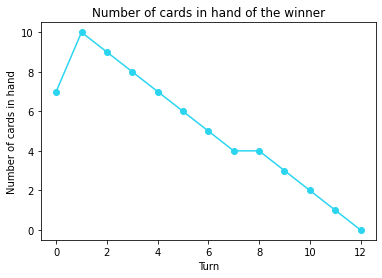

In [48]:
if(finishedGame):
    plt.figure()
    plt.plot(gameData.getWinnerData(), color = "#2bd5f0", marker = "o")
    plt.ylabel("Number of cards in hand")
    plt.xlabel("Turn")
    plt.title("Number of cards in hand of the winner")
else:
    print("No winner in this one")

In [49]:
def getHistogram(xArray, nBins = -1):
    if(nBins == -1):
        nBins = int(np.sqrt(len(xArray)))
    minValue = np.min(xArray)
    maxValue = np.max(xArray)
    binSize = (maxValue - minValue)/nBins
    
    histogram = np.zeros(nBins)
    xValues = np.linspace(minValue, maxValue, nBins)
    for i in range(0,len(xArray)):
        binIndex = int((xArray[i] - minValue)/binSize)
        if(binIndex == nBins):
            binIndex = nBins-1
        histogram[binIndex] = histogram[binIndex] + 1
    
    histogram = histogram/sum(histogram)
    return xValues, histogram

    

### Let's do some experiments

In [50]:
nWinningSteps = []
maxCardsAnyPlayer = []
maxCardsWinningPlayer = []

nExperiments = 1000

nPlayers = 4
unoGame = UNOGame(nPlayers)
description = False

for i in range(0,nExperiments):
    unoGame.initializeGame()
    finishedGame, gameData = unoGame.simulateGame(description)
    if(finishedGame):
        nCardsSeriesWinner = gameData.getWinnerData()
        winningSteps = len(nCardsSeriesWinner)
        maxCardsWinning = np.max(nCardsSeriesWinner)
        maxCardsAny = float('-inf')
        for j in range(0,nPlayers):
            data = gameData.getPlayerData(j)
            maxData = np.max(data)
            if(maxData > maxCardsAny):
                maxCardsAny = maxData
        nWinningSteps.append(winningSteps)
        maxCardsAnyPlayer.append(maxCardsAny)
        maxCardsWinningPlayer.append(maxCardsWinning)
                
                
#Let's get the distribution of the examined stochastic variables
xDistWinSteps, distWinSteps = getHistogram(nWinningSteps)
xDistMaxWinCards, distMaxWinCards = getHistogram(maxCardsWinningPlayer)
xDistMaxCardsAny, distMaxCardsAny = getHistogram(maxCardsAnyPlayer)


(7.0, 35.0)

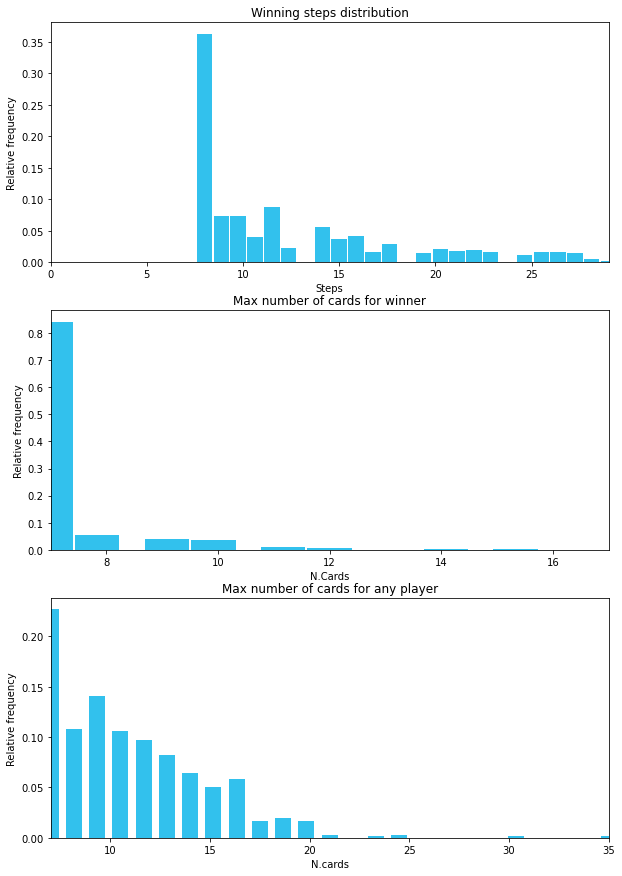

In [51]:
fig,ax = plt.subplots(3,1, figsize = (10,15))
ax[0].bar(xDistWinSteps, distWinSteps, color = "#32c1ed", edgecolor = "none")
ax[0].set_title("Winning steps distribution")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Relative frequency")
ax[0].set_xlim([0,np.max(nWinningSteps)])
ax[1].bar(xDistMaxWinCards, distMaxWinCards, color = "#32c1ed", edgecolor = "none")
ax[1].set_title("Max number of cards for winner")
ax[1].set_xlabel("N.Cards")
ax[1].set_ylabel("Relative frequency")
ax[1].set_xlim([7,np.max(maxCardsWinningPlayer)])
ax[2].bar(xDistMaxCardsAny, distMaxCardsAny, color = "#32c1ed", edgecolor = "none")
ax[2].set_title("Max number of cards for any player")
ax[2].set_xlabel("N.cards")
ax[2].set_ylabel("Relative frequency")
ax[2].set_xlim([7,np.max(maxCardsAnyPlayer)])

In [52]:
print("The mean number of turns of the winning player is "+str(np.mean(nWinningSteps)))
print("The mean number of max cards of the winning player is "+str(np.mean(maxCardsWinningPlayer)))
print("The mean number of max cards of any player is "+str(np.mean(maxCardsAnyPlayer)))

The mean number of turns of the winning player is 12.54320987654321
The mean number of max cards of the winning player is 7.3996913580246915
The mean number of max cards of any player is 11.425925925925926


These results apply only if everyone abides by the same strategñy, which is:
<ol>
    <li>Whenever you have a number card to play use it</li>
<li>If you don't have a number card to play, play some effect card (either reverse card, take two or skip card)</li>
    <li>Use take four or wild card if you have nothing else</li>
<li>If none of the above options are available then you take cards until you get something useful (play anything useful you get, no hoarding wild cards!)</li>
    </ol>


It would be interesting to see how emotions play out in all this. We could in principle define a player that is more likely to play something affecting other players that are doing very well or that previously played something that affected him/her.

Neutral strategies like the one examined in this notebook make for quick games, where the most affected player will get around 12 cards top. Maybe UNO is so frustrating because we make it so!, when we play attacking other players. I'll try to examine if this is true in some future version of this code. 